James Murphy. 09/05/2024

# Example dashboard

## Filled polygon

fill() draws a filled polygon based on lists of point coordinates x, y.

This example uses the Koch snowflake as an example polygon.

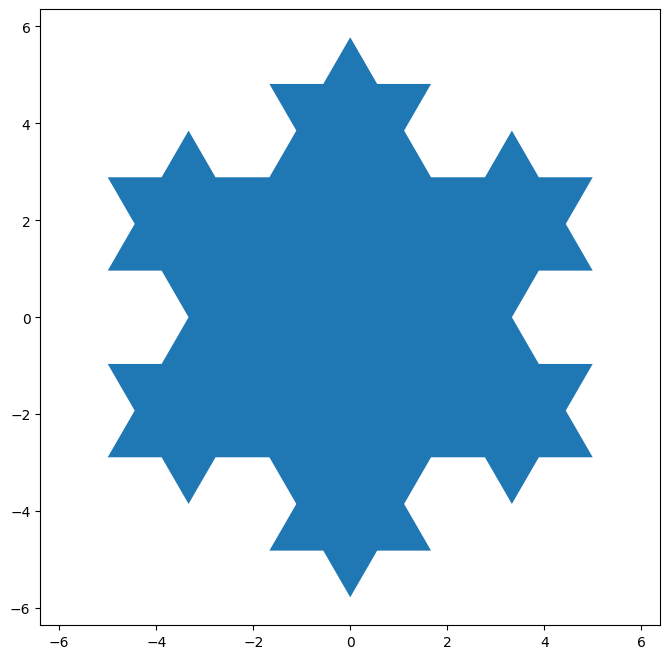

In [11]:
import matplotlib.pyplot as plt
import numpy as np


def koch_snowflake(order, scale=10):
    """
    Return two lists x, y of point coordinates of the Koch snowflake.

    Parameters
    ----------
    order : int
        The recursion depth.
    scale : float
        The extent of the snowflake (edge length of the base triangle).
    """
    def _koch_snowflake_complex(order):
        if order == 0:
            # initial triangle
            angles = np.array([0, 120, 240]) + 90
            return scale / np.sqrt(3) * np.exp(np.deg2rad(angles) * 1j)
        else:
            ZR = 0.5 - 0.5j * np.sqrt(3) / 3

            p1 = _koch_snowflake_complex(order - 1)  # start points
            p2 = np.roll(p1, shift=-1)  # end points
            
            dp = p2 - p1  # connection vectors

            new_points = np.empty(len(p1) * 4, dtype=np.complex128)
            new_points[::4] = p1
            new_points[1::4] = p1 + dp / 3
            new_points[2::4] = p1 + dp * ZR
            new_points[3::4] = p1 + dp / 3 * 2
            return new_points

    points = _koch_snowflake_complex(order)
    x, y = points.real, points.imag
    return x, y


x, y = koch_snowflake(order=2)  # change the number to make more or less fractally

plt.figure(figsize=(8, 8))
plt.axis('equal')
plt.fill(x, y)
plt.show()

# Filling the area between lines

#### Example: Confidence bands

A common application for fill_between is the indication of confidence bands.

fill_between uses the colors of the color cycle as the fill color. These may be a bit strong when applied to fill areas. It is therefore often a good practice to lighten the color by making the area semi-transparent using alpha.

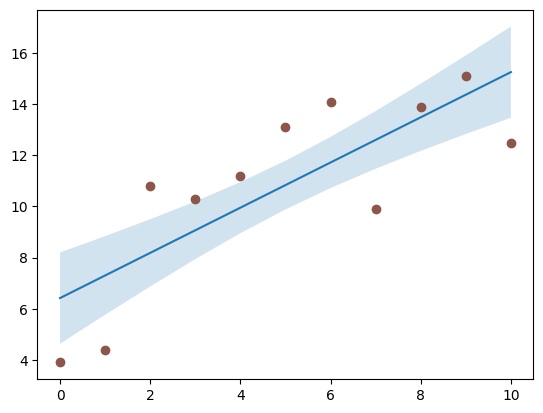

In [12]:
N = 21
x = np.linspace(0, 10, 11)
y = [3.9, 4.4, 10.8, 10.3, 11.2, 13.1, 14.1,  9.9, 13.9, 15.1, 12.5]

# fit a linear curve and estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = x.std() * np.sqrt(1/len(x) +
                          (x - x.mean())**2 / np.sum((x - x.mean())**2))

fig, ax = plt.subplots()
ax.plot(x, y_est, '-')
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
ax.plot(x, y, 'o', color='tab:brown')

## Percentiles as horizontal bar chart

Bar charts are useful for visualizing counts, or summary statistics with error bars. Also see the Grouped bar chart with labels or the Horizontal bar chart example for simpler versions of those features.

This example comes from an application in which grade school gym teachers wanted to be able to show parents how their child did across a handful of fitness tests, and importantly, relative to how other children did. To extract the plotting code for demo purposes, we'll just make up some data for little Johnny Doe.

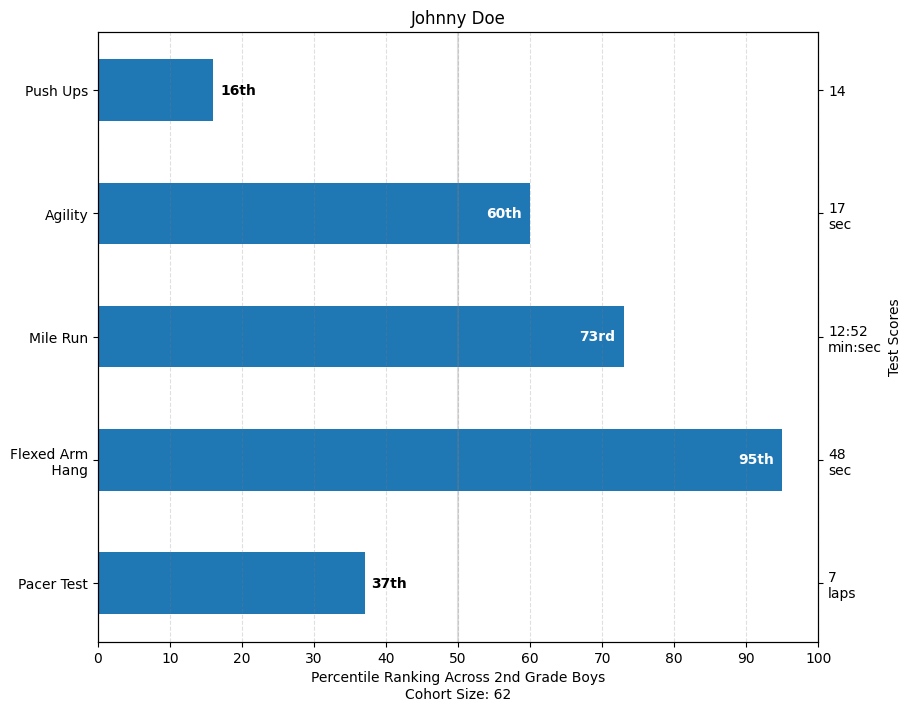

In [13]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np

Student = namedtuple('Student', ['name', 'grade', 'gender'])
Score = namedtuple('Score', ['value', 'unit', 'percentile'])


def to_ordinal(num):
    """Convert an integer to an ordinal string, e.g. 2 -> '2nd'."""
    suffixes = {str(i): v
                for i, v in enumerate(['th', 'st', 'nd', 'rd', 'th',
                                       'th', 'th', 'th', 'th', 'th'])}
    v = str(num)
    # special case early teens
    if v in {'11', '12', '13'}:
        return v + 'th'
    return v + suffixes[v[-1]]


def format_score(score):
    """
    Create score labels for the right y-axis as the test name followed by the
    measurement unit (if any), split over two lines.
    """
    return f'{score.value}\n{score.unit}' if score.unit else str(score.value)


def plot_student_results(student, scores_by_test, cohort_size):
    fig, ax1 = plt.subplots(figsize=(9, 7), layout='constrained')
    fig.canvas.manager.set_window_title('Eldorado K-8 Fitness Chart')

    ax1.set_title(student.name)
    ax1.set_xlabel(
        'Percentile Ranking Across {grade} Grade {gender}s\n'
        'Cohort Size: {cohort_size}'.format(
            grade=to_ordinal(student.grade),
            gender=student.gender.title(),
            cohort_size=cohort_size))

    test_names = list(scores_by_test.keys())
    percentiles = [score.percentile for score in scores_by_test.values()]

    rects = ax1.barh(test_names, percentiles, align='center', height=0.5)
    # Partition the percentile values to be able to draw large numbers in
    # white within the bar, and small numbers in black outside the bar.
    large_percentiles = [to_ordinal(p) if p > 40 else '' for p in percentiles]
    small_percentiles = [to_ordinal(p) if p <= 40 else '' for p in percentiles]
    ax1.bar_label(rects, small_percentiles,
                  padding=5, color='black', fontweight='bold')
    ax1.bar_label(rects, large_percentiles,
                  padding=-32, color='white', fontweight='bold')

    ax1.set_xlim([0, 100])
    ax1.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    ax1.xaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
    ax1.axvline(50, color='grey', alpha=0.25)  # median position

    # Set the right-hand Y-axis ticks and labels
    ax2 = ax1.twinx()
    # Set equal limits on both yaxis so that the ticks line up
    ax2.set_ylim(ax1.get_ylim())
    # Set the tick locations and labels
    ax2.set_yticks(
        np.arange(len(scores_by_test)),
        labels=[format_score(score) for score in scores_by_test.values()])

    ax2.set_ylabel('Test Scores')


student = Student(name='Johnny Doe', grade=2, gender='Boy')
scores_by_test = {
    'Pacer Test': Score(7, 'laps', percentile=37),
    'Flexed Arm\n Hang': Score(48, 'sec', percentile=95),
    'Mile Run': Score('12:52', 'min:sec', percentile=73),
    'Agility': Score(17, 'sec', percentile=60),
    'Push Ups': Score(14, '', percentile=16),
}

plot_student_results(student, scores_by_test, cohort_size=62)
plt.show()